In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models, torchvision
from torchvision.datasets import Caltech256
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import time

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
data = Caltech256(root="./data", download=True ,transform=transform)

Files already downloaded and verified


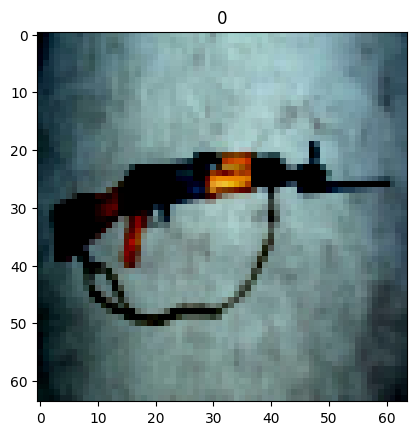

In [ ]:
for i,j in data:
  plt.imshow(i.permute(1,2,0))
  plt.title(j)
  break

In [ ]:
train = torch.utils.data.Subset(data,list(range(int(len(data)*0.7))))
train_dataset = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

test = torch.utils.data.Subset(data,list(range(int(len(data)*0.9),int(len(data)))))
test_dataset = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)

val = torch.utils.data.Subset(data,list(range(int(len(data)*0.7),int(len(data)*0.9))))
val_dataset = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True)

In [ ]:
model1 = models.inception_v3(pretrained=True)

In [ ]:
for param in model1.parameters():
    param.requires_grad = False

In [ ]:
fc_inputs = model1.fc.in_features
model1.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.max_pool2d()
    nn.Linear(256, 10),
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [ ]:
loss_criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model1.parameters(),lr=0.001)
device = "cpu"
epochs = 2
train_data_size = len(train_dataset)
test_data_size = len(test_dataset)
valid_data_size = len(val_dataset)

In [ ]:
x,y = next(iter(train_dataset))

In [ ]:
x[0].shape

torch.Size([3, 64, 64])

In [ ]:
history = []

for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        # Set to training mode
        model1.train()
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
        for i, (inputs, labels) in enumerate(train_dataset):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Clean existing gradients
            optimizer.zero_grad()
            # Forward pass - compute outputs on input data using the model
            outputs = model1(inputs)
            # Compute loss
            loss = loss_criterion(outputs, labels)
            # Backpropagate the gradients
            loss.backward()
            # Update the parameters
            optimizer.step()
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))
    # Validation - No gradient tracking needed
        with torch.no_grad():
            # Set to evaluation mode
            model1.eval()
            # Validation loop
            for j, (inputs, labels) in enumerate(val_dataset):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Forward pass - compute outputs on input data using the model
                outputs = model1(inputs)
                # Compute loss
                loss = loss_criterion(outputs, labels)
                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)
                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)
                print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/float(train_data_size)
        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_acc = valid_acc/float(valid_data_size)
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
        epoch_end = time.time()
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, nttValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))


Epoch: 1/2


RuntimeError: Given input size: (768x2x2). Calculated output size: (768x0x0). Output size is too small

In [ ]:
for inputs, labels in train_dataset:
  print(inputs.shape,labels)
  break

torch.Size([32, 3, 32, 32]) tensor([134, 176, 108,  22,  79,  58, 104, 132, 128,  37,  83,   2,  33,  20,
         76,   7,   4, 116,  89,  91,  87,  12, 126,  78,  56, 127,  75, 144,
         40,  64, 157,  42])


In [ ]:
model = models.resnet18(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer with a new one
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 256)  # 256 is the number of classes in Caltech256

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataset:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dataset:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")

# Different using CIFAR

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Define transforms for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit model expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


100%|██████████| 170498071/170498071 [00:02<00:00, 58881216.97it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Load pre-trained ResNet model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer with a new one
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # CIFAR-10 has 10 classes

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Train the model
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        print(loss.item() * inputs.size(0))
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")


69.94721984863281
70.88590240478516
70.61727142333984
71.92140197753906
74.86235809326172
70.3673095703125
65.73509979248047
69.3842544555664
73.38822174072266
71.29350280761719
67.618408203125
69.45467376708984
65.86434173583984
62.54270935058594
62.827632904052734
63.874332427978516
68.46540069580078
59.96663284301758
69.69584655761719
61.36260986328125
64.82939147949219
67.72157287597656
61.34797668457031
60.13920593261719
52.641639709472656
61.4878044128418
59.29258728027344
56.391815185546875
56.30276870727539
59.76485061645508
63.97874450683594
56.89189910888672
60.7709846496582
55.437191009521484
58.198638916015625
55.44472122192383
53.5350227355957
53.3018684387207
52.95934295654297
56.457027435302734
55.218284606933594
51.81633377075195
54.31955337524414
52.628570556640625
52.41146469116211
52.837425231933594
54.65049362182617
49.95806884765625
48.659053802490234
54.65113830566406
48.11105728149414
52.365211486816406
52.77241516113281
48.56397247314453
48.51786422729492
54.670